<a href="https://colab.research.google.com/github/gvtsch/Udemy_TensorFlow_Certificate/blob/main/10_time_series_forecasting_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time series forecasting fundamental with TensorFlow + Milestone Project 3: BitPredict 💰

Let's write some TensorFlow code to predict the price of Bitcoin based on the historical price of Bitcoin.

⚠ **Note:** This is not financial advice.

Links:
* All resources: https://github.com/mrdbourke/tensorflow-deep-learning
* Book version of actual code/text: https://github.com/mrdbourke/tensorflow-deep-learning/blob/main/10_time_series_forecasting_in_tensorflow.ipynb

## Get data

We're going to be using the historica price data of Bitcoin to try and predict the future price of Bitcoin.

To follow along the video with using the same data i am using the data from course's github repository. If i wanted to use other data i could download it e.g. [
  here](https://query1.finance.yahoo.com/v7/finance/download/BTC-USD?period1=1410912000&period2=1656460800&interval=1d&events=history&includeAdjustedClose=true)

In [1]:
import os
if not os.path.exists("BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv"):
  # !python -m wget !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
  !wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv


--2022-07-04 11:18:16--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 178509 (174K) [text/plain]
Saving to: ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’

BTC_USD_2013-10-01_ 100%[===================>] 174.33K  --.-KB/s    in 0.02s   

2022-07-04 11:18:16 (7.26 MB/s) - ‘BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv’ saved [178509/178509]



## Importing time series with pandas

In [2]:
# Import with pandas
import pandas as pd

# Let's read in our Bitcoin data and parse the dates
df = pd.read_csv("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv",
                 parse_dates=["Date"],
                 index_col=["Date"]) # parse the date column and tell pandas column 1 is a datetime

df.head()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2013-10-01,BTC,123.65499,124.30466,124.75166,122.56349
2013-10-02,BTC,125.45500,123.65499,125.75850,123.63383
2013-10-03,BTC,108.58483,125.45500,125.66566,83.32833
2013-10-04,BTC,118.67466,108.58483,118.67500,107.05816
2013-10-05,BTC,121.33866,118.67466,121.93633,118.00566


In [3]:
df.tail()

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2021-05-14,BTC,49764.132082,49596.778891,51448.798576,46294.720180
2021-05-15,BTC,50032.693137,49717.354353,51578.312545,48944.346536
2021-05-16,BTC,47885.625255,49926.035067,50690.802950,47005.102292
2021-05-17,BTC,45604.615754,46805.537852,49670.414174,43868.638969
2021-05-18,BTC,43144.471291,46439.336570,46622.853437,42102.346430


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2787 entries, 2013-10-01 to 2021-05-18
Data columns (total 5 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Currency             2787 non-null   object 
 1   Closing Price (USD)  2787 non-null   float64
 2   24h Open (USD)       2787 non-null   float64
 3   24h High (USD)       2787 non-null   float64
 4   24h Low (USD)        2787 non-null   float64
dtypes: float64(4), object(1)
memory usage: 130.6+ KB


In [5]:
# How many samples do we have?
len(df)

2787

We've collected the historical price of bitcoin for the past ~8 years but there's 2787 samples.

Typically deep learning models usually like lots and lots and lots of samples (where lots and lots and lots can be thousands to tens of thousands to millions).

A smaller number of samples is something you'll often run into with time series data problems.


> 🔑 **Note:** The **seasonality** of a time series dataset is referred as the number of samples per year. So for our Bitcoin data, it has a seasonality of daily or value of 365 because we collect one sample per day meaning we'll get 365 samples per year.

In [6]:
# We only want closing price for each day
bitcoin_prices = pd.DataFrame(df["Closing Price (USD)"]).rename(columns={"Closing Price (USD)": "Price"})
bitcoin_prices

,Price
Date,
2013-10-01,123.654990
2013-10-02,125.455000
2013-10-03,108.584830
2013-10-04,118.674660
2013-10-05,121.338660
...,...
2021-05-14,49764.132082
2021-05-15,50032.693137
2021-05-16,47885.625255


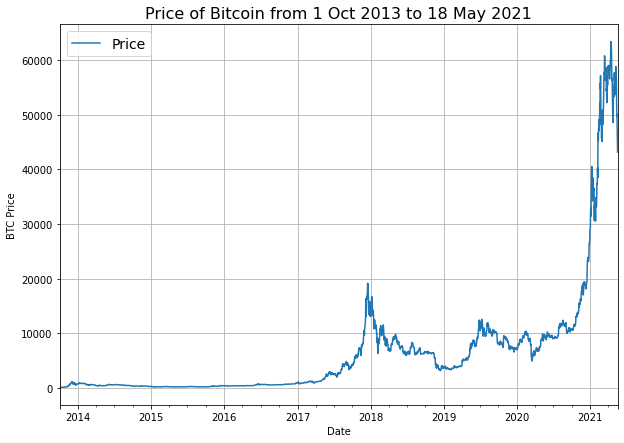

In [7]:
import matplotlib.pyplot as plt
bitcoin_prices.plot(figsize=(10, 7))
plt.ylabel("BTC Price")
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021", fontsize=16)
plt.legend(fontsize=14)
plt.grid()

## Importing time series data with Python's CSV module

In [8]:
# Importing and formatting historical Bitcoin data with Python
import csv
from datetime import datetime

timesteps = []
btc_price = []
with open("/content/BTC_USD_2013-10-01_2021-05-18-CoinDesk.csv", "r") as f:
  csv_reader = csv.reader(f, delimiter=",")
  next(csv_reader) # skip first line (this gets rid of the column titles)
  for line in csv_reader:
    timesteps.append(datetime.strptime(line[1], "%Y-%m-%d")) # get the dates as dates not strings
    btc_price.append(float(line[2])) # get the closing price as float

In [9]:
# View first 10 of each
timesteps[:10], btc_price[:10]

([datetime.datetime(2013, 10, 1, 0, 0),
  datetime.datetime(2013, 10, 2, 0, 0),
  datetime.datetime(2013, 10, 3, 0, 0),
  datetime.datetime(2013, 10, 4, 0, 0),
  datetime.datetime(2013, 10, 5, 0, 0),
  datetime.datetime(2013, 10, 6, 0, 0),
  datetime.datetime(2013, 10, 7, 0, 0),
  datetime.datetime(2013, 10, 8, 0, 0),
  datetime.datetime(2013, 10, 9, 0, 0),
  datetime.datetime(2013, 10, 10, 0, 0)],
 [123.65499,
  125.455,
  108.58483,
  118.67466,
  121.33866,
  120.65533,
  121.795,
  123.033,
  124.049,
  125.96116])

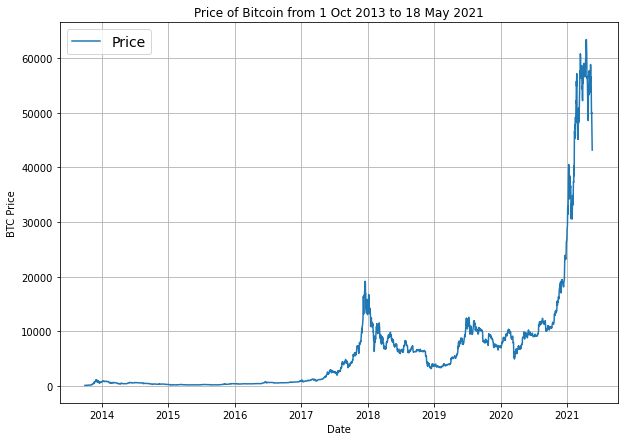

In [10]:
# Plot from csv
plt.figure(figsize=(10, 7))
plt.plot(timesteps, btc_price)
plt.title("Price of Bitcoin from 1 Oct 2013 to 18 May 2021")
plt.ylabel("BTC Price")
plt.xlabel("Date")
plt.legend(["Price"], fontsize=14)
plt.grid()

## Format data part 1: Create train and test sets of our time series data

### Creating train and test sets with time series data (the wrong way)

In [11]:
bitcoin_prices[:5]

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [12]:
# Get bitcoin date array
timesteps = bitcoin_prices.index.to_numpy()
prices = bitcoin_prices["Price"].to_numpy()
timesteps[:5], prices[:5]

(array(['2013-10-01T00:00:00.000000000', '2013-10-02T00:00:00.000000000',
        '2013-10-03T00:00:00.000000000', '2013-10-04T00:00:00.000000000',
        '2013-10-05T00:00:00.000000000'], dtype='datetime64[ns]'),
 array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866]))

In [13]:
# Wrong way to make train/test sets for time series data
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(timesteps, 
                                                    prices, 
                                                    test_size=0.2,
                                                    random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((2229,), (558,), (2229,), (558,))

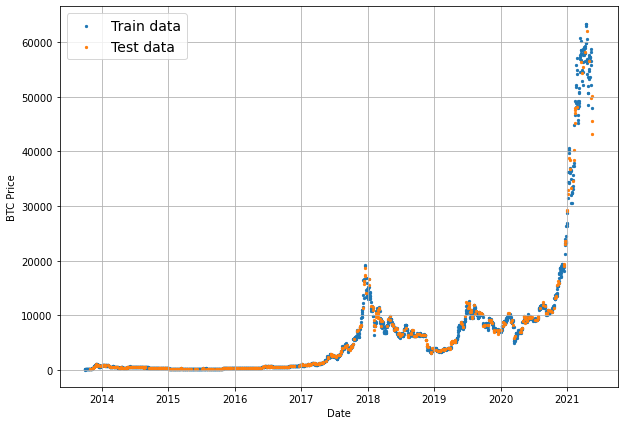

In [14]:
# Let's plot wrong train and test splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.grid()
plt.show()

### Create train and test sets for time series (the right way)

In [15]:
# Create train and test splits the right way for time series data
split_size = int(0.8 * len(prices)) # 80% train, 20% test

# Create train data splots (everything before the split)
x_train, y_train = timesteps[:split_size], prices[:split_size]

# Create test data splits (everything beyond the split)
x_test, y_test = timesteps[split_size:], prices[split_size:]

len(x_train), len(x_test), len(y_train), len(y_test)

(2229, 558, 2229, 558)

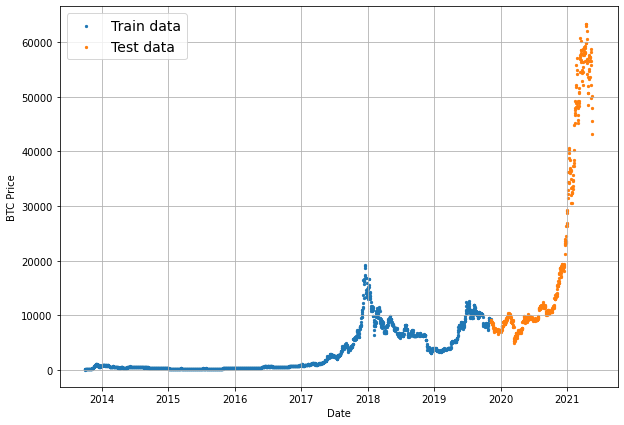

In [16]:
# Plot correctly made splits
plt.figure(figsize=(10, 7))
plt.scatter(x_train, y_train, s=5, label="Train data")
plt.scatter(x_test, y_test, s=5, label="Test data")
plt.xlabel("Date")
plt.ylabel("BTC Price")
plt.legend(fontsize=14)
plt.grid()
plt.show()

## Create a plotting function

Typing plotting code is tedious, let's functionize it.

In [17]:
# Create a function to plot time series data
def plot_time_series(timesteps, values, format=".", start=0, end=None, label=None):
  """
  Plots timesteps (a series of points in time) against values (a series of values across timesteps).
  
  Parameters
  ---
  timesteps : array of timestep values
  values : array of values across time
  format : style of plot, default "."
  start : where to start the plot (setting a value will indes from start of timesteps and values)
  end : where to end the plot (similoar to start but for the end)
  label : label to show on plot about values
  """

  # Plot the series
  plt.plot(timesteps[start:end], values[start:end], format, label=label)
  plt.xlabel("Time")
  plt.ylabel("BTC Price")
  if label: 
    plt.legend(fontsize=14) 
  plt.grid(True)


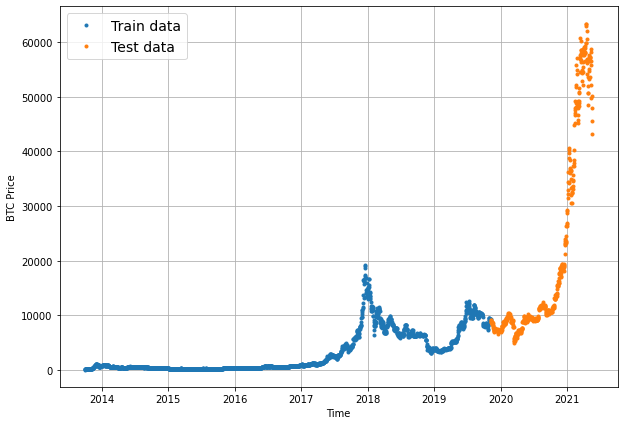

In [18]:
# Test out plotting function
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train data")
plot_time_series(timesteps=x_test, values=y_test, label="Test data")

## Modelling Experiments

We've got some Bitcoin historical data, to model it, let's run a series of modelling experiments and see which model performs best.

Terms to be familiar with:
* **Horizon** = number of timesteps into the future we're going to predict
* **Window** = number of timesteps we're going to use to predict horizon

Modelling experiments we're running:
0. Naïve model (baseline)
1. Dense model, horizon = 1, window = 7
2. Same as 1, horizon = 1, window = 30
3. Same as 1, horizon = 7, window = 30
4. Conv1D, horizon = 1, window = 7
5. LSTM, horizon = 1, window = 7
6. Same as 1 (but with mulitvariate data), horizon = 1, window = 7
7. N-BEATs Algorithm, horizon = 1, window = 7
8. Ensemble (multiple models optimized on different loss functions), horizon = 1, window = 7
9. Future prediction model (model to predict future values), horizon = 1, window = 7
10. Same as 1 (but with turkey 🦃 data introduced), horizon = 1, window = 7

## Model 0: Naïve Forecast (baseline)

The formula looks like this:

$$\hat{y}_{t} = y_{t-1}$$

In English:
> The prediction at timestep t (y-hat) is equal to the value at timestep t-1 (previous timestep) - this is for a horizon of 1.

In [19]:
y_test[:10], y_test[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([58788.20967893, 58102.19142623, 55715.54665129, 56573.5554719 ,
        52147.82118698, 49764.1320816 , 50032.69313676, 47885.62525472,
        45604.61575361, 43144.47129086]))

In [20]:
# Create a Naive forecast
naive_forecast = y_test[:-1]

naive_forecast[:10], naive_forecast[-10:]

(array([9226.48582088, 8794.35864452, 8798.04205463, 9081.18687849,
        8711.53433917, 8760.89271814, 8749.52059102, 8656.97092235,
        8500.64355816, 8469.2608989 ]),
 array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
        56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
        47885.62525472, 45604.61575361]))

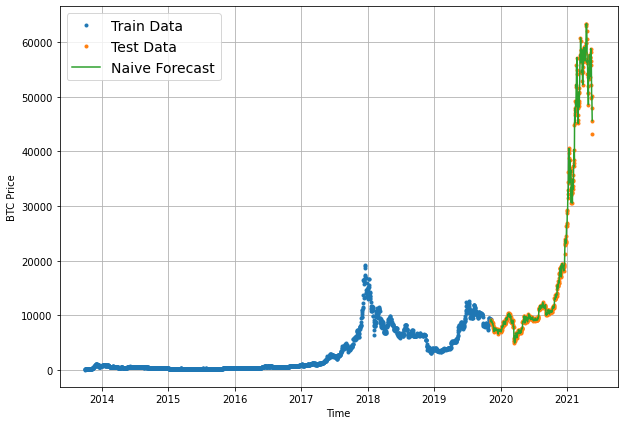

In [21]:
# Plot naive dorecast
plt.figure(figsize=(10, 7))
plot_time_series(timesteps=x_train, values=y_train, label="Train Data")
plot_time_series(timesteps=x_test, values=y_test, label="Test Data")
plot_time_series(timesteps=x_test[1:], values=naive_forecast, format="-", label="Naive Forecast")

## Evaluating a time series model

Let's look into some evaluation metrics for time series forecasting predictions.

What are we doing? 

We're predicting a number, so that means we have a form of a regression problem.

Because we're working on a regression problem, we'll need some regression-like metrics. 

A few common regression metrics (which can also be used for time series forecasting):
* MAE - Mean Absolute Error
* MSE - Mean Squared Error
* RMSE - Root Mean Squared Error
* MAPE = (Symmetric) Mean Absolute Percentage Error
* MASE - Mean Absolute scaled error

For all the aboive metrics, **lower is better**, for example, an MAE of 0 that is better than an MAE of 100.

The main thing we're evaluating here is: **How do our model's forecasts (y_pred) compare against the actual values (y_true or ground truth values)?**

In [22]:
import tensorflow as tf

In [23]:
# MASE implementation
def mean_absolute_scaled_error(y_true, y_pred):
  """
  Implement MASE (assuming no seasonality of data).
  """

  mae = tf.reduce_mean(tf.abs(y_true-y_pred))

  # Find MAE of naive forecast (no seasonality)
  mae_naive_no_season = tf.reduce_mean(tf.abs(y_true[1:]-y_true[:-1])) # our seasonality is 1 day (hence the shift of 1)

  return mae / mae_naive_no_season

In [24]:
# Test MASE (this value should = 1 or be very close to 1 with the naive forecast)
mean_absolute_scaled_error(y_true=y_test[1:], y_pred=naive_forecast).numpy()

0.9995699939182624

In [25]:
# Create a function to take in model predictions and truth values and return evaluation metrics
def evaluate_preds(y_true, y_pred):
  # Make sure float32 datatype (for metrics calculations)
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  return {
      "mae": mae.numpy(), 
      "mse": mse.numpy(),
      "rmse": rmse.numpy(),
      "mape": mape.numpy(),
      "mase": mase.numpy()
  }

That's one good looking evaluation function!

Let's now see if it works...

In [26]:
naive_results = evaluate_preds(
    y_true=y_test[1:], 
    y_pred=naive_forecast
)
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

In [27]:
naive_forecast[-10:]

array([57107.12067189, 58788.20967893, 58102.19142623, 55715.54665129,
       56573.5554719 , 52147.82118698, 49764.1320816 , 50032.69313676,
       47885.62525472, 45604.61575361])

In [28]:
tf.reduce_mean(y_test)

<tf.Tensor: shape=(), dtype=float64, numpy=20056.632963737226>

In [29]:
tf.reduce_min(y_test), tf.reduce_max(y_test)

(<tf.Tensor: shape=(), dtype=float64, numpy=4944.7023359837>,
 <tf.Tensor: shape=(), dtype=float64, numpy=63346.7890351052>)

## Other models you can use for baselines and for actual forecasts

In this notebook we're  focused on TensorFlow and deep learning models.

However there are plenty of other styles of time series forecasting models you may want to experiment with.

* [Moving average](https://machinelearningmastery.com/moving-average-smoothing-for-time-series-forecasting-python/)
* [ARIMA (Autoregression Integrated Moving Average)](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [sktime (Scikit-Learn for time series)](https://github.com/alan-turing-institute/sktime)
* [TensorFlow Decision Forests (random forest, gradient boosting trees)](https://www.tensorflow.org/decision_forests)
* [Facebook Kats (purpose-built forecasting and time series analysis library by Facebook)](https://github.com/facebookresearch/Kats)
* [LinkedIn Greykite (flexible, intuitive and fast forecasts)](https://github.com/linkedin/greykite)

## Format Data Part 2: Windowing our dataset

Why do we window?

We window our time series dataset to turn our data into a supervised learning problem.

```
Windowing for one week
[0, 1, 2, 3, 4, 5, 6] -> [7]
[1, 2, 3, 4, 5, 6, 7] -> [8]
[2, 3, 4, 5, 6, 7, 8] -> [9]
```

In [30]:
import numpy as np

In [31]:
btc_price[:10]

[123.65499,
 125.455,
 108.58483,
 118.67466,
 121.33866,
 120.65533,
 121.795,
 123.033,
 124.049,
 125.96116]

In [32]:
# What we want to do with our Bitcoin data
print(f"We want to use {btc_price[:7]} to predict {btc_price[7]}")

We want to use [123.65499, 125.455, 108.58483, 118.67466, 121.33866, 120.65533, 121.795] to predict 123.033


In [33]:
# Let's setup global variable for window and horizon size
HORIZON = 1
WINDOW_SIZE = 7

In [34]:
# Create function to label windowed data
def get_labelled_windows(x, horizon=HORIZON):
  """
  Creates labels for windowed dataset.

  E.g. if horizon=1
  Input: [0, 1, 2, 3, 4, 5, 6, 7] -> ([0, 1, 2, 3, 4, 5, 6], [7])
  """
  return x[:, :-horizon], x[:, -horizon:]

In [35]:
# Test out the window labelling function
test_window, test_label = get_labelled_windows(tf.expand_dims(tf.range(8), axis=0))
print(f"Window: {tf.squeeze(test_window).numpy()} -> Label {tf.squeeze(test_label.numpy())}")

Window: [0 1 2 3 4 5 6] -> Label 7


We've got a way to label our windowed data.

Howevee, this only works on a small scale.

We need a way tot do the above across our entire time series.

We could do this with python for loops, however, for large time series, that'd be quite slow.

To speed things up, we'll leverage NumPy's array indexing - https://numpy.org/doc/stable/reference/arrays.indexing.html

Our function will:
1. Create a window step of specific window size (e.g. [0, 1, 2, 3, 4, 5, 6])
2. Use NumPy indexing to create a 2D array of multiple window steps, for example 
```
[[0, 1, 2, 3, 4, 5, 6],
[1, 2, 3, 4, 5, 6, 7],
[2, 3, 4, 5, 6, 7, 8]]
```
3. Uses the 2D array of multiple window steps (from 2.) to index on a target series (e.g. the historical price of Bitcoin)
4. Uses our `get_labelled_window()` function we created above to turn the window steps into windows with a specified horizon.

> 📖 **Resource:** The function we're about to create has been adapted from the following article: https://towardsdatascience.com/fast-and-robust-sliding-window-vectorization-with-numpy-3ad950ed62f5

In [36]:
# Create function to view NumPy array as windows
def make_windows(x, window_size=WINDOW_SIZE, horizon=HORIZON):
  """
  Turns a 1D array into a 2D array of sequential labelled windows of window_size with horizon size labels.
  """
  # 1. Create a window of specific window_size (add the hoizon on the end for labelling later)
  window_step = np.expand_dims(np.arange(window_size+horizon), axis=0)

  # 2. Create a 2D array of multiple window steps (minus -1 to account for 0 indexing)
  window_indexes = window_step + np.expand_dims(np.arange(len(x)-(window_size+horizon-1)), axis=0).T 
    # create 2D array of windows of size window_size
  # print(f"Window indexes: \n{window_indexes, window_indexes.shape}")

  # 3. Index on the target array (a time series) with 2D Array of multiple window steps
  windowed_array = x[window_indexes]
  # print(windowed_array)

  # 4. Get the labeled windows
  windows, labels = get_labelled_windows(windowed_array, horizon=horizon)
  return windows, labels

In [37]:
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE)
len(full_windows), len(full_labels), len(prices)

(2780, 2780, 2787)

In [38]:
# View the first windows/labels
for i in range(3):
  print(f"Window: {full_windows[i]} -> Label: {full_labels[i]}")

Window: [123.65499 125.455   108.58483 118.67466 121.33866 120.65533 121.795  ] -> Label: [123.033]
Window: [125.455   108.58483 118.67466 121.33866 120.65533 121.795   123.033  ] -> Label: [124.049]
Window: [108.58483 118.67466 121.33866 120.65533 121.795   123.033   124.049  ] -> Label: [125.96116]


In [39]:
# View the last 3
for i in range(3):
  print(f"Window: {full_windows[i-3]}, Label: {full_labels[i-3]}")

Window: [58788.20967893 58102.19142623 55715.54665129 56573.5554719
 52147.82118698 49764.1320816  50032.69313676], Label: [47885.62525472]
Window: [58102.19142623 55715.54665129 56573.5554719  52147.82118698
 49764.1320816  50032.69313676 47885.62525472], Label: [45604.61575361]
Window: [55715.54665129 56573.5554719  52147.82118698 49764.1320816
 50032.69313676 47885.62525472 45604.61575361], Label: [43144.47129086]


In [40]:
prices[-1]

43144.4712908603

> 🔑 **Note:** You can find a function which achieces similar results to the ones we implemented above at [tf.keras.preprocessing.timeseries_dataset_from_array()](https://keras.io/api/preprocessing/timeseries/). Just like ours, it takes in an array and returns a windowed dataset. It has the benefit of returning data in the form of a tf.data.Dataset instance (we'll see how to do this with our own data later).

## Turning windows into training and test sets

In [41]:
full_windows[:5], full_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [42]:
# Make the train/test splits
def make_train_test_splits(windows, labels, test_split=0.2):
  """
  Splits matching pairs of windows and labels into train and test splits.
  """
  split_size = int(len(windows) * (1-test_split)) # this will default to 80% train/20% test
  train_windows = windows[:split_size]
  train_labels = labels[:split_size]
  test_windows = windows[split_size:]
  test_labels = labels[split_size:]
  return train_windows, test_windows, train_labels, test_labels

In [43]:
# Create train and test windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(full_windows, full_labels)
len(train_windows), len(test_windows), len(train_labels), len(test_labels), len(full_windows)*0.8

(2224, 556, 2224, 556, 2224.0)

In [44]:
train_windows[:5], train_labels[:5]

(array([[123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
         121.795  ],
        [125.455  , 108.58483, 118.67466, 121.33866, 120.65533, 121.795  ,
         123.033  ],
        [108.58483, 118.67466, 121.33866, 120.65533, 121.795  , 123.033  ,
         124.049  ],
        [118.67466, 121.33866, 120.65533, 121.795  , 123.033  , 124.049  ,
         125.96116],
        [121.33866, 120.65533, 121.795  , 123.033  , 124.049  , 125.96116,
         125.27966]]), array([[123.033  ],
        [124.049  ],
        [125.96116],
        [125.27966],
        [125.9275 ]]))

In [45]:
test_windows[:5], test_labels[:5]

(array([[9290.89660239, 9202.41545055, 9369.62808116, 9326.59962378,
         9335.75240233, 9226.48582088, 8794.35864452],
        [9202.41545055, 9369.62808116, 9326.59962378, 9335.75240233,
         9226.48582088, 8794.35864452, 8798.04205463],
        [9369.62808116, 9326.59962378, 9335.75240233, 9226.48582088,
         8794.35864452, 8798.04205463, 9081.18687849],
        [9326.59962378, 9335.75240233, 9226.48582088, 8794.35864452,
         8798.04205463, 9081.18687849, 8711.53433917],
        [9335.75240233, 9226.48582088, 8794.35864452, 8798.04205463,
         9081.18687849, 8711.53433917, 8760.89271814]]),
 array([[8798.04205463],
        [9081.18687849],
        [8711.53433917],
        [8760.89271814],
        [8749.52059102]]))

In [46]:
# Check to see if train labels are the same (before and after window split)
np.array_equal(np.squeeze(train_labels[:-HORIZON-1]), y_train[WINDOW_SIZE:])

True

## Make a modelling checkpoint callback

Because our model's performance will fluctuate from experiment to experiment, we're going to write a model checkpoint so we can compare apples to apples.

More specifically, we want to compare each of our model's best performances against the other model's best performances.

For example if our model performs the best on epoch 55 (but we're training for 100 epochs), we want to load and evaluate the model saved on epoch 55.

We can create a modelling checkpoint callback using the following: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/ModelCheckpoint

In [47]:
import os

# Create a function to implement a ModelCheckpoint callback with a specific filename 
def create_model_checkpoint(model_name, save_path="model_experiments"):
  return tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(save_path, model_name), # create filepath to save model
                                            verbose=0, # only output a limited amount of text
                                            save_best_only=True) # save only the best model to file

## Model 1: Dense model (window=7, horizon=1)

Our first deep model is going to be a simple dense model:
* A single dense layer with 128 hidden units and ReLU
* An output layer with linear activation (no activation)
* Adam optimizer and MAE loss function
* Batch size of 128 (previously we've used 32)
* 100 epochs

Why these values?

Picked them out of experimentation.

* *Hyperparameters* = values a machine learning practitioner (me!) can adjust myself.
  * See: https://towardsdatascience.com/hyperparameter-tuning-with-kerastuner-and-tensorflow-c4a4d690b31a
* **Parameters** = values a model learns on its own

In [48]:
import tensorflow as tf
from tensorflow.keras import layers

# Set random seed
tf.random.set_seed(42)

# 1. Model
model_1 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_1_dense")

# 2. Compile
model_1.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

# 3. Fit
model_1.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    verbose=0,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[
      create_model_checkpoint(model_name=model_1.name)
    ]
)

INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_1_dense/assets
INFO:tensorflow:Assets written to: mod

In [49]:
# Evaluate model on test data
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 662.5322 - mae: 662.5322


[662.5322265625, 662.5322265625]

In [50]:
# Load in saved best performing model_1 and evaluate it on test data
model_1 = tf.keras.models.load_model("model_experiments/model_1_dense/")
model_1.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 568.5499 - mae: 568.5499


[568.5498657226562, 568.5498657226562]

### Making forecasts with a model (on the test dataset)

To make forecasts on the test dataset (note: these won't be actual forecasts, they're only pseudo forecasts because actual forecasts are into the future), let's wirte a function to:

1. Take in a train model
2. Takes in some input data (same kind of data the model was trained on)
3. Passes the input data to the model's `predict()` method
4. Returns the predictions

In [51]:
def make_preds(model, input_data):
  """ 
  Uses model to make predictions on input_data.
  """
  forecast = model.predict(input_data)
  return tf.squeeze(forecast) # return 1-D array of predictions

In [52]:
# Make predictions using model_1 on the test dataset and view results
model_1_preds = make_preds(model_1, test_windows)
len(model_1_preds), model_1_preds[:10]

(556, <tf.Tensor: shape=(10,), dtype=float32, numpy=
 array([8874.493, 8789.944, 9040.986, 8804.829, 8741.21 , 8749.835,
        8705.865, 8513.171, 8478.415, 8536.302], dtype=float32)>)

In [53]:
test_labels.shape, model_1_preds.shape

((556, 1), TensorShape([556]))

In [54]:
# Evaluate preds
model_1_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_1_preds)
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

In [55]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

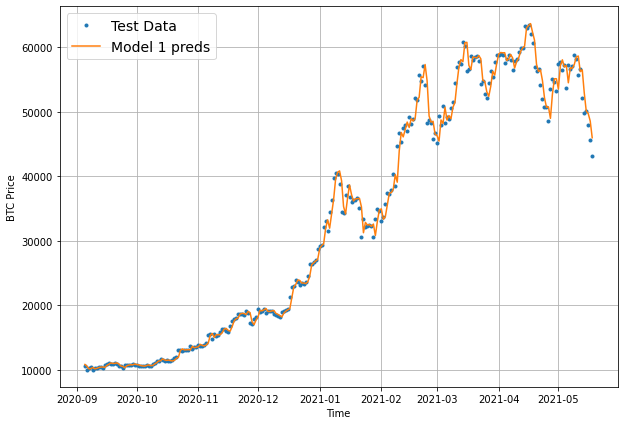

In [56]:
# Let's plot our model_1 predictions
offset = 300
plt.figure(figsize=(10, 7))
# Account for the test_window offset and index into test_labels to ensure correct plotting
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=test_labels[:, 0], 
    start=offset, 
    label="Test Data"
)
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=model_1_preds,
    start=offset,
    format="-",
    label="Model 1 preds"
)

## Model 2: Dense (window=30, horizon=1)


In [57]:
WINDOW_SIZE=30
HORIZON=1

In [58]:
# Make window data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(full_windows), len(full_labels)

(2757, 2757)

In [59]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels,
    test_split=0.2
)

In [60]:
tf.random.set_seed(42)

# Model 2
model_2 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_2_dense")

# Compile
model_2.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

# Fit
model_2.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    validation_data=(test_windows, test_labels),
    verbose=0,
    batch_size=128,
    callbacks=[
      create_model_checkpoint(model_name=model_2.name)
    ]
)

INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_2_dense/assets
INFO:tensorflow:Assets written to: mod

In [61]:
# Load in saved best performing model_1 and evaluate it on test data
model_2 = tf.keras.models.load_model("model_experiments/model_2_dense/")
model_2.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 608.8480 - mae: 608.8480


[608.8480224609375, 608.8480224609375]

### Making forecasts

In [62]:
model_2_preds = make_preds(model_2, test_windows)
model_2_preds[-10:]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([56825.27 , 59047.63 , 58355.285, 57038.727, 56018.46 , 54154.688,
       49806.98 , 51226.5  , 48485.57 , 47112.715], dtype=float32)>

In [63]:
# Evaluate preds
model_2_results = evaluate_preds(y_true=tf.squeeze(test_labels), y_pred=model_2_preds)
model_2_results

{'mae': 608.84814,
 'mape': 2.7680664,
 'mase': 1.0642724,
 'mse': 1284314.4,
 'rmse': 1133.276}

In [64]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

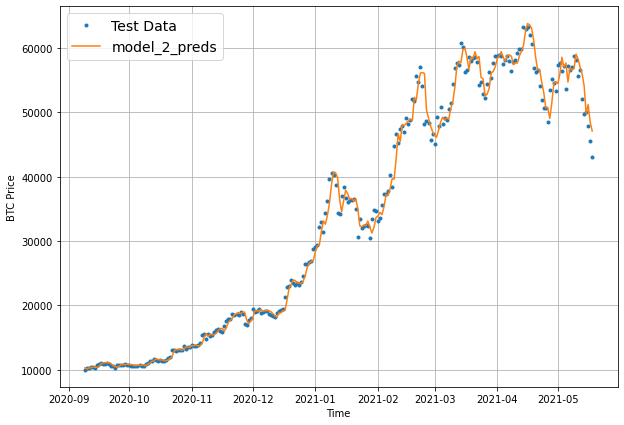

In [65]:
offset = 300

plt.figure(figsize=(10, 7))
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=test_labels[:, 0], 
    start=offset, 
    label="Test Data"
)
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=model_2_preds, 
    start=offset, format="-", 
    label="model_2_preds"
)

## **Model 3**: Dense (window=30, horizon=7)

Let's ty and predict 7 days given the previous 30 days.**Text fett markieren**

In [66]:
HORIZON = 7
WINDOW_SIZE = 30

In [67]:
# Make window data with appropriate horizon and window size
full_windows, full_labels = make_windows(prices, window_size=WINDOW_SIZE, horizon=HORIZON)
len(train_windows), len(test_windows), len(train_labels), len(test_labels), len(full_windows)*0.8

(2205, 552, 2205, 552, 2200.8)

In [68]:
# Make train and testing windows
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    windows=full_windows,
    labels=full_labels,
    test_split=0.2
)

In [69]:
# Model 3
model_3 = tf.keras.Sequential([
  layers.Dense(128, activation="relu"),
  layers.Dense(HORIZON, activation="linear")
], name="model_3_dense")

# Compile
model_3.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

# Fit
model_3.fit(
    x=train_windows,
    y=train_labels,
    epochs=100,
    validation_data=(test_windows, test_labels),
    verbose=0,
    batch_size=128,
    callbacks=[
      create_model_checkpoint(model_name=model_3.name)
    ]
)

INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: model_experiments/model_3_dense/assets
INFO:tensorflow:Assets written to: mod

In [70]:
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1332.0151 - mae: 1332.0151


[1332.01513671875, 1332.01513671875]

In [71]:
# Load in best version of model_3 and evaluate
model_3 = tf.keras.models.load_model("model_experiments/model_3_dense/")
model_3.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 1247.9972 - mae: 1247.9972


[1247.9971923828125, 1247.9971923828125]

### Making forecasts

In [72]:
model_3_preds = make_preds(
    model_3, 
    input_data=test_windows
)
model_3_preds[-5:]

<tf.Tensor: shape=(5, 7), dtype=float32, numpy=
array([[56635.83 , 57524.54 , 58213.344, 57628.953, 57200.72 , 57035.457,
        57279.76 ],
       [57826.812, 56566.863, 57760.11 , 56611.566, 58175.016, 57849.89 ,
        58080.387],
       [58732.33 , 58032.67 , 59060.293, 58774.63 , 59073.812, 59163.367,
        60058.85 ],
       [58451.703, 57740.207, 59235.047, 59138.13 , 60068.9  , 60725.117,
        60206.65 ],
       [57420.04 , 57396.   , 58323.016, 59167.527, 59339.426, 59042.79 ,
        58675.92 ]], dtype=float32)>

In [73]:
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)

### Make our evaluation function work for larger horizons

In [74]:
def evaluate_preds(y_true, y_pred):
  y_true = tf.cast(y_true, dtype=tf.float32)
  y_pred = tf.cast(y_pred, dtype=tf.float32)

  # Calculate various evaluation metrics
  mae = tf.keras.metrics.mean_absolute_error(y_true, y_pred)
  mse = tf.keras.metrics.mean_squared_error(y_true, y_pred)
  rmse = tf.sqrt(mse)
  mape = tf.keras.metrics.mean_absolute_percentage_error(y_true, y_pred)
  mase = mean_absolute_scaled_error(y_true, y_pred)

  # Account for differenz sized metrics (for longer horizons, reduce to single number)
  if mae.ndim > 0: # if mae isn't already a scalar, reduce it to one by aggregating tensors to mean
    mae = tf.reduce_mean(mae)
    mse = tf.reduce_mean(mse)
    rmse = tf.reduce_mean(rmse)
    mape = tf.reduce_mean(mape)
    mase = tf.reduce_mean(mase)

  return {"mae": mae.numpy(),
          "mse": mse.numpy(),
          "rmse": rmse.numpy(),
          "mape": mape.numpy(),
          "mase": mase.numpy()}

In [75]:
# Get model_3 results aggregated to single values
model_3_results = evaluate_preds(y_true=tf.squeeze(test_labels),
                                 y_pred=model_3_preds)
model_3_results

{'mae': 1247.9972,
 'mape': 5.667339,
 'mase': 2.2207413,
 'mse': 5503063.5,
 'rmse': 1431.8477}

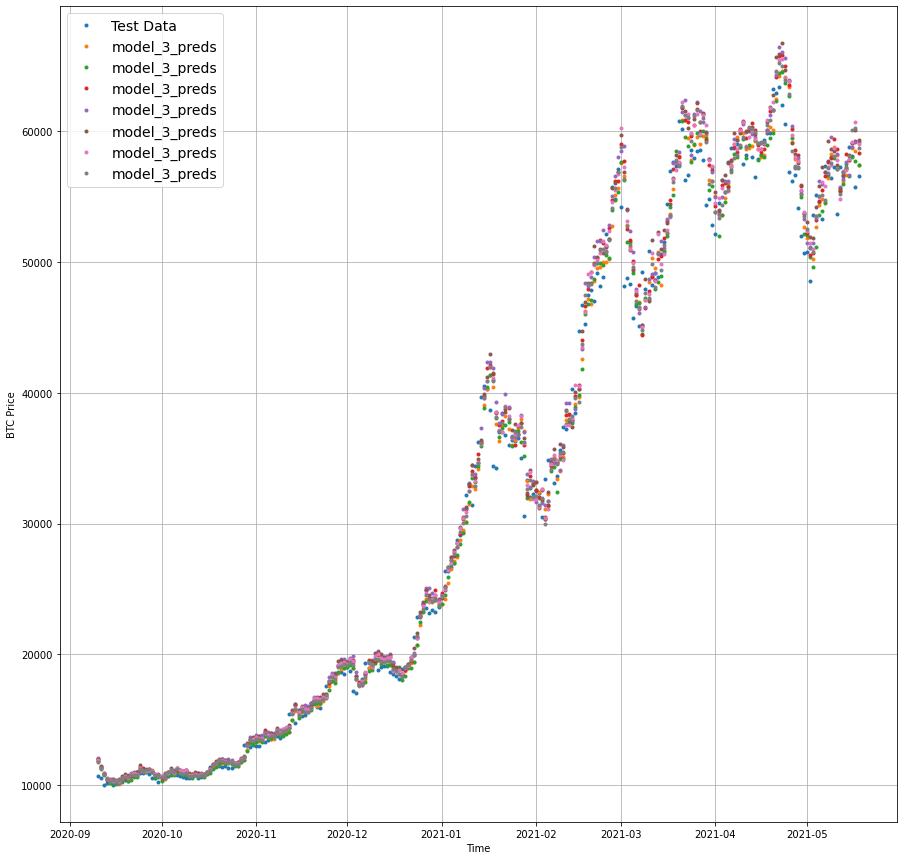

In [76]:
offset = 300
plt.figure(figsize=(15, 15))
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=test_labels[:, 0], 
    start=offset, 
    label="Test Data"
)
plot_time_series(
    timesteps=x_test[-len(test_windows):], 
    values=model_3_preds, 
    start=offset, 
    label="model_3_preds"
)

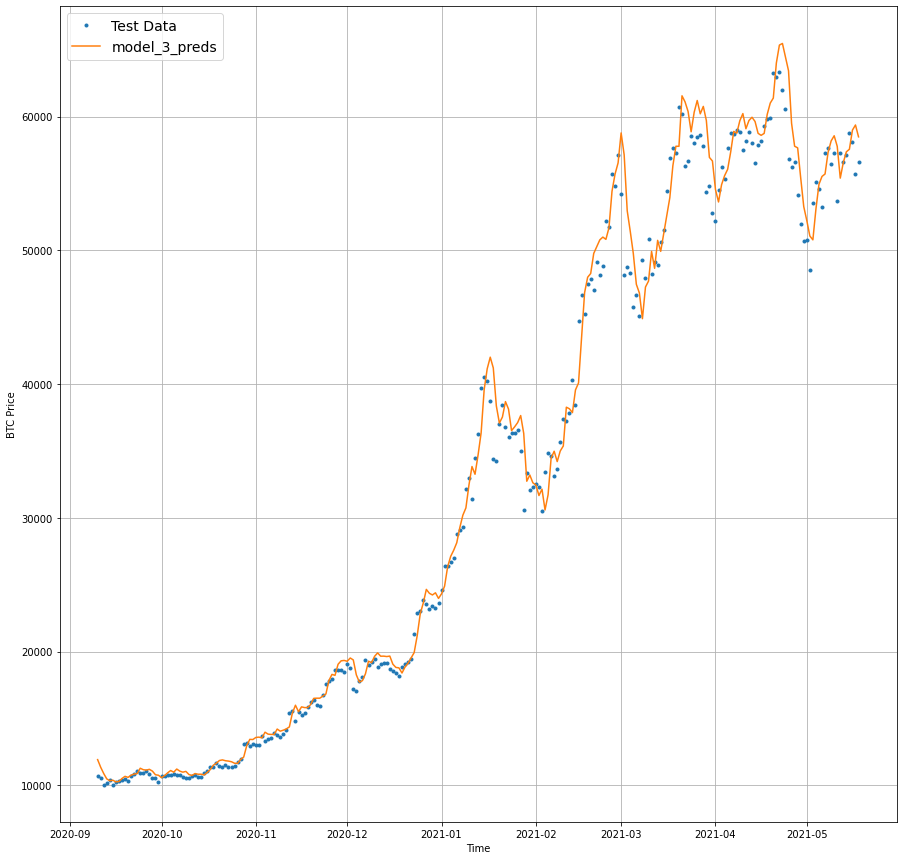

In [77]:
offset = 300
plt.figure(figsize=(15, 15))
plot_time_series(
    timesteps=x_test[-len(test_windows):],
    values=test_labels[:, 0],
    start=offset,
    label="Test Data"
)
plot_time_series(
    timesteps=x_test[-len(test_windows):],
    values=tf.reduce_mean(model_3_preds, axis = 1),
    format="-",
    start=offset,
    label="model_3_preds"
)

## Which of our models is performing the best so far?

So we've trained a few models, now let's compare them and see how they've gone ...

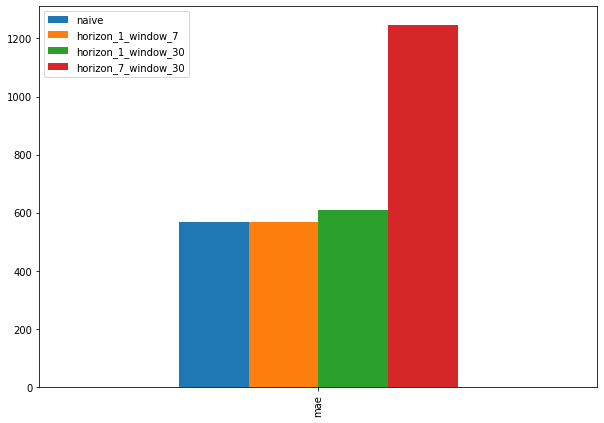

In [78]:
pd.DataFrame({
    "naive": naive_results["mae"],
    "horizon_1_window_7": model_1_results["mae"],
    "horizon_1_window_30": model_2_results["mae"],
    "horizon_7_window_30": model_3_results["mae"]},
  index=["mae"]).plot(
      figsize=(10, 7), 
      kind="bar"
      )

> 🔑 **Note:** You might be wonderung, why are the naive results so good? One of the reasons could be due the presence of autocorrelation in the data. If a time series has autocorrelation it means the value at `t+1` (the next timestep) is typically close to the value at `t` (the current timestep). In other words, today's value is probably close to yesterday's value. Of course this isn't always the case but when it is (stock market prices often seem autocorrelated but often fluctuate randomly), a naive model will often get fairly good results.

> 📖 **Ressource:** For more on how autocorrelation influences a model's predictions, see the article [How (not) to use Machine Learning for time series forecasting: Avoiding the pitfalls](https://www.linkedin.com/pulse/how-use-machine-learning-time-series-forecasting-vegard-flovik-phd/)

## Model 4: Conv1D



In [79]:
HORIZON = 1
WINDOW_SIZE = 7

In [80]:
# Create the windowed data
full_windows, full_labels = make_windows(
    prices, 
    window_size=WINDOW_SIZE,
    horizon=HORIZON)
len(full_windows), len(full_labels)

(2780, 2780)

In [81]:
# Create train/test sets
train_windows, test_windows, train_labels, test_labels = make_train_test_splits(
    full_windows, 
    full_labels)
len(train_windows), len(train_labels), len(test_windows), len(test_labels)

(2224, 2224, 556, 556)

To use the Conv1D layer, we need an input shape of `(batch_size, timesteps, input_dims)`...

However our data isn't in that shape yet...

In [82]:
# Check data input shape
train_windows[0].shape

(7,)

In [83]:
# Before we pass our data to the Conv1D layer, we have to reshape it to make sure it works
x = tf.constant(train_windows[0])
x

<tf.Tensor: shape=(7,), dtype=float64, numpy=
array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])>

In [84]:
expand_dims_layer = layers.Lambda(lambda x: tf.expand_dims(x, axis=1)) # Add an extra dimension for input dim

In [85]:
# Test out our lambda layer
print(f"Original shape: {x.shape}\nExpanded shape:{expand_dims_layer(x).shape}")
print(f"Original values with expanded shape:\n{expand_dims_layer(x)}")

Original shape: (7,)
Expanded shape:(7, 1)
Original values with expanded shape:
[[123.65499]
 [125.455  ]
 [108.58483]
 [118.67466]
 [121.33866]
 [120.65533]
 [121.795  ]]


In [86]:
x.numpy()

array([123.65499, 125.455  , 108.58483, 118.67466, 121.33866, 120.65533,
       121.795  ])

In [87]:
tf.random.set_seed(42)

# Create a Conv1D 
model_4 = tf.keras.Sequential([
  layers.Lambda(lambda x: tf.expand_dims(x, axis=1)),
  layers.Conv1D(filters=128, kernel_size=7, padding="causal", strides=1, activation="relu"),
  layers.Dense(HORIZON)
], name="model_4_Conv1D")

# Compile
model_4.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"])

In [88]:
# Fit
model_4.fit(
    train_windows,
    train_labels,
    batch_size=128,
    epochs=100,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_4.name)])

Epoch 1/100
18/18 [==============================] - 2s 59ms/step - loss: 1486.8625 - mae: 1486.8625 - val_loss: 1494.0219 - val_mae: 1494.0219
Epoch 2/100
18/18 [==============================] - 0s 5ms/step - loss: 359.4608 - mae: 359.4608 - val_loss: 1882.3615 - val_mae: 1882.3615
Epoch 3/100
18/18 [==============================] - 1s 47ms/step - loss: 237.6436 - mae: 237.6436 - val_loss: 1228.3146 - val_mae: 1228.3146
Epoch 4/100
18/18 [==============================] - 1s 46ms/step - loss: 208.6003 - mae: 208.6003 - val_loss: 1095.6528 - val_mae: 1095.6528
Epoch 5/100
18/18 [==============================] - 1s 46ms/step - loss: 197.1489 - mae: 197.1489 - val_loss: 1088.0098 - val_mae: 1088.0098
Epoch 6/100
18/18 [==============================] - 1s 46ms/step - loss: 192.2837 - mae: 192.2837 - val_loss: 1075.7446 - val_mae: 1075.7446
Epoch 7/100
18/18 [==============================] - 1s 47ms/step - loss: 191.2738 - mae: 191.2738 - val_loss: 1050.4635 - val_mae: 1050.4635
Epoch

In [89]:
model_4.summary()

Model: "model_4_Conv1D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lambda_1 (Lambda)           (None, 1, 7)              0         
                                                                 
 conv1d (Conv1D)             (None, 1, 128)            6400      
                                                                 
 dense_6 (Dense)             (None, 1, 1)              129       
                                                                 
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


In [90]:
# Evaluate model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 609.9927 - mae: 609.9927


[609.99267578125, 609.99267578125]

In [91]:
# Load best model
model_4 = tf.keras.models.load_model("model_experiments/model_4_Conv1D")

In [92]:
# Evaluate best model
model_4.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 570.3994 - mae: 570.3994


[570.3993530273438, 570.3993530273438]

In [93]:
# Make predictions first
model_4_preds = make_preds(model_4, test_windows)
model_4_preds[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=
array([8897.537 , 8793.336 , 9025.615 , 8800.965 , 8748.348 , 8769.1875,
       8684.735 , 8543.161 , 8480.019 , 8531.297 ], dtype=float32)>

In [94]:
# Evaluate predictions
model_4_results = evaluate_preds(
    y_true=tf.squeeze(test_labels),
    y_pred=model_4_preds)
model_4_results

{'mae': 570.39935,
 'mape': 2.5455725,
 'mase': 1.0020337,
 'mse': 1182763.1,
 'rmse': 1087.5492}

In [95]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

## Model 5: RNN (LSTM)

Let's build an RNN model for our time series data.

We'll use the same data we created previously.

In [96]:
tf.random.set_seed(42)

# Let's build an LSTM model with the Functional API
inputs = layers.Input(shape=(WINDOW_SIZE))
x = layers.Lambda(lambda x: tf.expand_dims(x, axis=1))(inputs)
# x = layers.LSTM(128, return_sequences=True)(x)
x = layers.LSTM(128, activation="relu")(x)
# x = layers.Dense(32, activation="relu")(x)
outputs = layers.Dense(HORIZON)(x)

model_5 = tf.keras.Model(inputs=inputs, outputs=outputs, name="model_5_LSTM")

In [97]:
model_5.compile(
    loss="mae",
    optimizer=tf.keras.optimizers.Adam(),
    metrics=["mae"]
)

In [98]:
model_5.fit(
    train_windows,
    train_labels,
    epochs=100,
    batch_size=128,
    validation_data=(test_windows, test_labels),
    callbacks=[create_model_checkpoint(model_name=model_5.name)])

Epoch 1/100
10/18 [===============>..............] - ETA: 0s - loss: 2581.3245 - mae: 2581.3245 INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 4s 146ms/step - loss: 2323.6123 - mae: 2323.6123 - val_loss: 9224.3506 - val_mae: 9224.3506
Epoch 2/100
17/18 [===========================>..] - ETA: 0s - loss: 706.6860 - mae: 706.6860  INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 153ms/step - loss: 695.4956 - mae: 695.4956 - val_loss: 1485.8942 - val_mae: 1485.8942
Epoch 3/100
17/18 [===========================>..] - ETA: 0s - loss: 239.3258 - mae: 239.3258INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 144ms/step - loss: 237.3010 - mae: 237.3010 - val_loss: 1298.9436 - val_mae: 1298.9436
Epoch 4/100
18/18 [==============================] - ETA: 0s - loss: 181.9182 - mae: 181.9182INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 181.9182 - mae: 181.9182 - val_loss: 966.6407 - val_mae: 966.6407
Epoch 5/100
18/18 [==============================] - 0s 9ms/step - loss: 173.4021 - mae: 173.4021 - val_loss: 970.9384 - val_mae: 970.9384
Epoch 6/100
10/18 [===============>..............] - ETA: 0s - loss: 169.4054 - mae: 169.4054INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 132ms/step - loss: 172.3319 - mae: 172.3319 - val_loss: 891.5209 - val_mae: 891.5209
Epoch 7/100
18/18 [==============================] - 0s 9ms/step - loss: 168.9708 - mae: 168.9708 - val_loss: 968.6377 - val_mae: 968.6377
Epoch 8/100
18/18 [==============================] - 0s 9ms/step - loss: 169.5318 - mae: 169.5318 - val_loss: 963.4456 - val_mae: 963.4456
Epoch 9/100
18/18 [==============================] - 0s 8ms/step - loss: 167.5760 - mae: 167.5760 - val_loss: 956.5829 - val_mae: 956.5829
Epoch 10/100
18/18 [==============================] - 0s 9ms/step - loss: 166.3443 - mae: 166.3443 - val_loss: 936.8956 - val_mae: 936.8956
Epoch 11/100
18/18 [==============================] - 0s 9ms/step - loss: 165.4762 - mae: 165.4762 - val_loss: 909.1110 - val_mae: 909.1110
Epoch 12/100
18/18 [==============================] - ETA: 0s - loss: 169.9951 - mae: 169.9951INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 156ms/step - loss: 169.9951 - mae: 169.9951 - val_loss: 891.2327 - val_mae: 891.2327
Epoch 13/100
18/18 [==============================] - 0s 9ms/step - loss: 160.3806 - mae: 160.3806 - val_loss: 898.5595 - val_mae: 898.5595
Epoch 14/100
18/18 [==============================] - 0s 8ms/step - loss: 157.6484 - mae: 157.6484 - val_loss: 927.9266 - val_mae: 927.9266
Epoch 15/100
18/18 [==============================] - 0s 9ms/step - loss: 167.6508 - mae: 167.6508 - val_loss: 982.9256 - val_mae: 982.9256
Epoch 16/100
18/18 [==============================] - 0s 10ms/step - loss: 160.4521 - mae: 160.4521 - val_loss: 916.0458 - val_mae: 916.0458
Epoch 17/100
18/18 [==============================] - 0s 8ms/step - loss: 153.8805 - mae: 153.8805 - val_loss: 928.6927 - val_mae: 928.6927
Epoch 18/100
10/18 [===============>..............] - ETA: 0s - loss: 162.7562 - mae: 162.7562INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 134ms/step - loss: 152.1556 - mae: 152.1556 - val_loss: 865.6219 - val_mae: 865.6219
Epoch 19/100
18/18 [==============================] - 0s 9ms/step - loss: 148.8319 - mae: 148.8319 - val_loss: 876.9328 - val_mae: 876.9328
Epoch 20/100
18/18 [==============================] - ETA: 0s - loss: 149.6801 - mae: 149.6801INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 135ms/step - loss: 149.6801 - mae: 149.6801 - val_loss: 831.2376 - val_mae: 831.2376
Epoch 21/100
15/18 [========================>.....] - ETA: 0s - loss: 145.5328 - mae: 145.5328INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 145.7330 - mae: 145.7330 - val_loss: 821.0629 - val_mae: 821.0629
Epoch 22/100
18/18 [==============================] - 0s 10ms/step - loss: 143.9433 - mae: 143.9433 - val_loss: 821.2911 - val_mae: 821.2911
Epoch 23/100
18/18 [==============================] - 0s 8ms/step - loss: 143.1268 - mae: 143.1268 - val_loss: 837.1895 - val_mae: 837.1895
Epoch 24/100
14/18 [======================>.......] - ETA: 0s - loss: 141.6198 - mae: 141.6198INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 178ms/step - loss: 141.0378 - mae: 141.0378 - val_loss: 808.0547 - val_mae: 808.0547
Epoch 25/100
15/18 [========================>.....] - ETA: 0s - loss: 144.1336 - mae: 144.1336INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 139.0068 - mae: 139.0068 - val_loss: 787.0112 - val_mae: 787.0112
Epoch 26/100
18/18 [==============================] - ETA: 0s - loss: 137.9395 - mae: 137.9395INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 142ms/step - loss: 137.9395 - mae: 137.9395 - val_loss: 769.2203 - val_mae: 769.2203
Epoch 27/100
18/18 [==============================] - 0s 10ms/step - loss: 136.4498 - mae: 136.4498 - val_loss: 772.5977 - val_mae: 772.5977
Epoch 28/100
18/18 [==============================] - ETA: 0s - loss: 135.2745 - mae: 135.2745INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 169ms/step - loss: 135.2745 - mae: 135.2745 - val_loss: 751.0115 - val_mae: 751.0115
Epoch 29/100
18/18 [==============================] - 0s 9ms/step - loss: 135.5958 - mae: 135.5958 - val_loss: 759.8718 - val_mae: 759.8718
Epoch 30/100
18/18 [==============================] - 0s 9ms/step - loss: 138.2377 - mae: 138.2377 - val_loss: 789.2983 - val_mae: 789.2983
Epoch 31/100
15/18 [========================>.....] - ETA: 0s - loss: 131.8530 - mae: 131.8530INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 151ms/step - loss: 133.4514 - mae: 133.4514 - val_loss: 730.3293 - val_mae: 730.3293
Epoch 32/100
18/18 [==============================] - 0s 9ms/step - loss: 129.2459 - mae: 129.2459 - val_loss: 730.9674 - val_mae: 730.9674
Epoch 33/100
16/18 [=========================>....] - ETA: 0s - loss: 129.9039 - mae: 129.9039INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 144ms/step - loss: 128.6682 - mae: 128.6682 - val_loss: 726.6902 - val_mae: 726.6902
Epoch 34/100
16/18 [=========================>....] - ETA: 0s - loss: 128.8947 - mae: 128.8947INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 133ms/step - loss: 128.9641 - mae: 128.9641 - val_loss: 708.2340 - val_mae: 708.2340
Epoch 35/100
10/18 [===============>..............] - ETA: 0s - loss: 125.0531 - mae: 125.0531INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 171ms/step - loss: 126.4375 - mae: 126.4375 - val_loss: 702.6016 - val_mae: 702.6016
Epoch 36/100
18/18 [==============================] - ETA: 0s - loss: 125.8648 - mae: 125.8648INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 139ms/step - loss: 125.8648 - mae: 125.8648 - val_loss: 696.0234 - val_mae: 696.0234
Epoch 37/100
10/18 [===============>..............] - ETA: 0s - loss: 116.4368 - mae: 116.4368INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 124.2744 - mae: 124.2744 - val_loss: 692.3998 - val_mae: 692.3998
Epoch 38/100
15/18 [========================>.....] - ETA: 0s - loss: 124.9941 - mae: 124.9941INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 123.4617 - mae: 123.4617 - val_loss: 682.3129 - val_mae: 682.3129
Epoch 39/100
18/18 [==============================] - 0s 10ms/step - loss: 124.4908 - mae: 124.4908 - val_loss: 689.1117 - val_mae: 689.1116
Epoch 40/100
18/18 [==============================] - 0s 10ms/step - loss: 123.6601 - mae: 123.6601 - val_loss: 688.7414 - val_mae: 688.7414
Epoch 41/100
15/18 [========================>.....] - ETA: 0s - loss: 125.5659 - mae: 125.5659INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 179ms/step - loss: 121.6996 - mae: 121.6996 - val_loss: 673.3080 - val_mae: 673.3080
Epoch 42/100
16/18 [=========================>....] - ETA: 0s - loss: 120.5581 - mae: 120.5581INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 146ms/step - loss: 121.2662 - mae: 121.2662 - val_loss: 665.5682 - val_mae: 665.5682
Epoch 43/100
17/18 [===========================>..] - ETA: 0s - loss: 120.8663 - mae: 120.8663INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 138ms/step - loss: 121.1914 - mae: 121.1914 - val_loss: 663.4371 - val_mae: 663.4371
Epoch 44/100
18/18 [==============================] - 0s 9ms/step - loss: 121.3492 - mae: 121.3492 - val_loss: 666.4625 - val_mae: 666.4625
Epoch 45/100
16/18 [=========================>....] - ETA: 0s - loss: 117.9707 - mae: 117.9707INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 119.4222 - mae: 119.4222 - val_loss: 653.1441 - val_mae: 653.1441
Epoch 46/100
18/18 [==============================] - ETA: 0s - loss: 119.1475 - mae: 119.1475INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 146ms/step - loss: 119.1475 - mae: 119.1475 - val_loss: 649.3669 - val_mae: 649.3669
Epoch 47/100
18/18 [==============================] - 0s 9ms/step - loss: 119.5113 - mae: 119.5113 - val_loss: 650.3450 - val_mae: 650.3450
Epoch 48/100
17/18 [===========================>..] - ETA: 0s - loss: 117.7157 - mae: 117.7157INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 140ms/step - loss: 117.9849 - mae: 117.9849 - val_loss: 643.7015 - val_mae: 643.7015
Epoch 49/100
18/18 [==============================] - 0s 9ms/step - loss: 117.3458 - mae: 117.3458 - val_loss: 649.1431 - val_mae: 649.1431
Epoch 50/100
18/18 [==============================] - 0s 9ms/step - loss: 119.0112 - mae: 119.0112 - val_loss: 658.5665 - val_mae: 658.5665
Epoch 51/100
18/18 [==============================] - 0s 9ms/step - loss: 118.3833 - mae: 118.3833 - val_loss: 673.2418 - val_mae: 673.2418
Epoch 52/100
18/18 [==============================] - 0s 10ms/step - loss: 118.0016 - mae: 118.0016 - val_loss: 644.5724 - val_mae: 644.5724
Epoch 53/100
14/18 [======================>.......] - ETA: 0s - loss: 117.6709 - mae: 117.6709INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 135ms/step - loss: 117.5012 - mae: 117.5012 - val_loss: 632.1457 - val_mae: 632.1457
Epoch 54/100
18/18 [==============================] - 0s 8ms/step - loss: 117.3330 - mae: 117.3330 - val_loss: 637.2055 - val_mae: 637.2055
Epoch 55/100
18/18 [==============================] - ETA: 0s - loss: 115.8615 - mae: 115.8615INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 115.8615 - mae: 115.8615 - val_loss: 627.7058 - val_mae: 627.7058
Epoch 56/100
18/18 [==============================] - 0s 9ms/step - loss: 117.1814 - mae: 117.1814 - val_loss: 648.4813 - val_mae: 648.4813
Epoch 57/100
18/18 [==============================] - 0s 9ms/step - loss: 125.8361 - mae: 125.8361 - val_loss: 648.9831 - val_mae: 648.9831
Epoch 58/100
18/18 [==============================] - 0s 9ms/step - loss: 115.4787 - mae: 115.4787 - val_loss: 630.3375 - val_mae: 630.3375
Epoch 59/100
18/18 [==============================] - 0s 10ms/step - loss: 114.6559 - mae: 114.6559 - val_loss: 628.4244 - val_mae: 628.4244
Epoch 60/100
17/18 [===========================>..] - ETA: 0s - loss: 113.3809 - mae: 113.3809INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 144ms/step - loss: 114.8021 - mae: 114.8021 - val_loss: 620.0607 - val_mae: 620.0607
Epoch 61/100
18/18 [==============================] - 0s 10ms/step - loss: 114.3845 - mae: 114.3845 - val_loss: 633.4195 - val_mae: 633.4195
Epoch 62/100
18/18 [==============================] - 0s 10ms/step - loss: 114.7735 - mae: 114.7735 - val_loss: 653.0529 - val_mae: 653.0529
Epoch 63/100
18/18 [==============================] - 0s 10ms/step - loss: 118.5447 - mae: 118.5447 - val_loss: 622.3017 - val_mae: 622.3017
Epoch 64/100
18/18 [==============================] - 0s 10ms/step - loss: 113.3439 - mae: 113.3439 - val_loss: 646.4648 - val_mae: 646.4648
Epoch 65/100
18/18 [==============================] - 0s 10ms/step - loss: 115.5774 - mae: 115.5774 - val_loss: 621.8207 - val_mae: 621.8207
Epoch 66/100
18/18 [==============================] - 0s 11ms/step - loss: 113.5758 - mae: 113.5758 - val_loss: 625.8535 - val_mae: 625.8535
Epoch 67/100
14/18 [=====

INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 147ms/step - loss: 114.3274 - mae: 114.3274 - val_loss: 618.1777 - val_mae: 618.1777
Epoch 68/100
14/18 [======================>.......] - ETA: 0s - loss: 117.0965 - mae: 117.0965INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 167ms/step - loss: 115.8874 - mae: 115.8874 - val_loss: 610.0667 - val_mae: 610.0667
Epoch 69/100
18/18 [==============================] - 0s 11ms/step - loss: 118.1946 - mae: 118.1946 - val_loss: 630.6259 - val_mae: 630.6259
Epoch 70/100
18/18 [==============================] - 0s 10ms/step - loss: 117.6780 - mae: 117.6780 - val_loss: 613.6976 - val_mae: 613.6976
Epoch 71/100
18/18 [==============================] - 0s 11ms/step - loss: 112.6891 - mae: 112.6891 - val_loss: 628.7469 - val_mae: 628.7469
Epoch 72/100
18/18 [==============================] - 0s 9ms/step - loss: 115.3159 - mae: 115.3159 - val_loss: 613.3113 - val_mae: 613.3113
Epoch 73/100
14/18 [======================>.......] - ETA: 0s - loss: 113.5761 - mae: 113.5761INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 148ms/step - loss: 112.2513 - mae: 112.2513 - val_loss: 607.5436 - val_mae: 607.5436
Epoch 74/100
18/18 [==============================] - 0s 9ms/step - loss: 113.5405 - mae: 113.5405 - val_loss: 612.9193 - val_mae: 612.9193
Epoch 75/100
18/18 [==============================] - 0s 9ms/step - loss: 114.6243 - mae: 114.6243 - val_loss: 680.9974 - val_mae: 680.9974
Epoch 76/100
18/18 [==============================] - 0s 9ms/step - loss: 114.3978 - mae: 114.3978 - val_loss: 627.7791 - val_mae: 627.7791
Epoch 77/100
18/18 [==============================] - 0s 10ms/step - loss: 115.0701 - mae: 115.0701 - val_loss: 677.3135 - val_mae: 677.3135
Epoch 78/100
18/18 [==============================] - 0s 10ms/step - loss: 115.6408 - mae: 115.6408 - val_loss: 638.9863 - val_mae: 638.9863
Epoch 79/100
17/18 [===========================>..] - ETA: 0s - loss: 114.2517 - mae: 114.2517INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 141ms/step - loss: 113.8102 - mae: 113.8102 - val_loss: 603.6312 - val_mae: 603.6312
Epoch 80/100
18/18 [==============================] - 0s 9ms/step - loss: 111.6164 - mae: 111.6164 - val_loss: 621.9382 - val_mae: 621.9382
Epoch 81/100
18/18 [==============================] - 0s 9ms/step - loss: 111.7110 - mae: 111.7110 - val_loss: 620.0795 - val_mae: 620.0795
Epoch 82/100
18/18 [==============================] - ETA: 0s - loss: 114.4341 - mae: 114.4341INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 133ms/step - loss: 114.4341 - mae: 114.4341 - val_loss: 598.3356 - val_mae: 598.3356
Epoch 83/100
18/18 [==============================] - 0s 9ms/step - loss: 112.8585 - mae: 112.8585 - val_loss: 607.5803 - val_mae: 607.5803
Epoch 84/100
18/18 [==============================] - 0s 8ms/step - loss: 111.8406 - mae: 111.8406 - val_loss: 602.6411 - val_mae: 602.6411
Epoch 85/100
18/18 [==============================] - 0s 10ms/step - loss: 111.2613 - mae: 111.2613 - val_loss: 627.6544 - val_mae: 627.6544
Epoch 86/100
18/18 [==============================] - 0s 9ms/step - loss: 113.9645 - mae: 113.9645 - val_loss: 619.5224 - val_mae: 619.5224
Epoch 87/100
16/18 [=========================>....] - ETA: 0s - loss: 114.0054 - mae: 114.0054INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 162ms/step - loss: 113.8286 - mae: 113.8286 - val_loss: 598.2933 - val_mae: 598.2933
Epoch 88/100
16/18 [=========================>....] - ETA: 0s - loss: 113.1223 - mae: 113.1223INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 137ms/step - loss: 110.8448 - mae: 110.8448 - val_loss: 596.0640 - val_mae: 596.0640
Epoch 89/100
18/18 [==============================] - 0s 9ms/step - loss: 111.0922 - mae: 111.0922 - val_loss: 630.6047 - val_mae: 630.6047
Epoch 90/100
18/18 [==============================] - 0s 9ms/step - loss: 115.8214 - mae: 115.8214 - val_loss: 680.3810 - val_mae: 680.3810
Epoch 91/100
18/18 [==============================] - 0s 8ms/step - loss: 116.0425 - mae: 116.0425 - val_loss: 632.1270 - val_mae: 632.1270
Epoch 92/100
18/18 [==============================] - ETA: 0s - loss: 111.9858 - mae: 111.9858INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 134ms/step - loss: 111.9858 - mae: 111.9858 - val_loss: 596.0399 - val_mae: 596.0399
Epoch 93/100
18/18 [==============================] - 0s 10ms/step - loss: 111.9554 - mae: 111.9554 - val_loss: 601.6699 - val_mae: 601.6699
Epoch 94/100
18/18 [==============================] - 0s 8ms/step - loss: 110.7805 - mae: 110.7805 - val_loss: 605.7480 - val_mae: 605.7480
Epoch 95/100
18/18 [==============================] - ETA: 0s - loss: 110.1889 - mae: 110.1889INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 134ms/step - loss: 110.1889 - mae: 110.1889 - val_loss: 594.1672 - val_mae: 594.1672
Epoch 96/100
18/18 [==============================] - 0s 10ms/step - loss: 112.3372 - mae: 112.3372 - val_loss: 601.4485 - val_mae: 601.4485
Epoch 97/100
18/18 [==============================] - 0s 8ms/step - loss: 110.8521 - mae: 110.8521 - val_loss: 625.3636 - val_mae: 625.3636
Epoch 98/100
16/18 [=========================>....] - ETA: 0s - loss: 112.4198 - mae: 112.4198INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 3s 159ms/step - loss: 110.8161 - mae: 110.8161 - val_loss: 594.1018 - val_mae: 594.1018
Epoch 99/100
17/18 [===========================>..] - ETA: 0s - loss: 110.2074 - mae: 110.2074INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


INFO:tensorflow:Assets written to: model_experiments/model_5_LSTM/assets


18/18 [==============================] - 2s 131ms/step - loss: 109.7159 - mae: 109.7159 - val_loss: 591.6655 - val_mae: 591.6655
Epoch 100/100
18/18 [==============================] - 0s 9ms/step - loss: 112.6171 - mae: 112.6171 - val_loss: 594.9865 - val_mae: 594.9865


In [99]:
# Load in best version of model_5 and evaluate on test data
model_5 = tf.keras.models.load_model("model_experiments/model_5_LSTM")
model_5.evaluate(test_windows, test_labels)

18/18 [==============================] - 0s 2ms/step - loss: 591.6655 - mae: 591.6655


[591.6654663085938, 591.6654663085938]

In [100]:
# Make predictions
model_5_preds = make_preds(model_5, test_windows)
model_5_preds[:5]

<tf.Tensor: shape=(5,), dtype=float32, numpy=array([8970.957, 8815.352, 9026.793, 8831.478, 8736.686], dtype=float32)>

In [101]:
# Evaluate model_5 predictions
model_5_results = evaluate_preds(
    y_true=tf.squeeze(test_labels), 
    y_pred=model_5_preds)
model_5_results

{'mae': 591.6655,
 'mape': 2.66558,
 'mase': 1.0393925,
 'mse': 1250831.5,
 'rmse': 1118.4058}

In [102]:
model_1_results

{'mae': 568.5498,
 'mape': 2.549229,
 'mase': 0.99878454,
 'mse': 1172587.6,
 'rmse': 1082.8608}

> 🔑 **Note:** Because neural networks are such powerful algorithms, they can be used for almost any problem, however, that doesn't mean they'll achieve performant or usable results. You're probably starting to clue onto this now.

In [104]:
naive_results

{'mae': 567.9802,
 'mape': 2.5165248,
 'mase': 0.99957,
 'mse': 1147547.0,
 'rmse': 1071.2362}

## Make a multivariate timeseries dataset

Before we add a feature to our time series, what is a feautre we can use?

One feature we could add is whether or not Daniel Bourke tweeted on that day ...

* day 1 - 0
* day 2 - 1
* day 3 - 0

What's a better feature to use?

How about the Bitcoin halving events?

In [105]:
# Let's make a multivariate time series
bitcoin_prices.head()

,Price
Date,
2013-10-01,123.65499
2013-10-02,125.45500
2013-10-03,108.58483
2013-10-04,118.67466
2013-10-05,121.33866


In [112]:
# Let's add the bitcoin halving events to this dataset
block_reward_1 = 50 # 3 Jan 2009 - this block reward isn't in our dataset (starts 2013)
block_reward_2 = 25 # 28 Nov 2012 - not included, too
block_reward_3 = 12.5 # 9 Jul 2016
block_reward_4 = 6.25 # 18 May 2020

# Block reward dates
block_reward_2_datetime = np.datetime64("2012-11-28")
block_reward_3_datetime = np.datetime64("2016-07-09")
block_reward_4_datetime = np.datetime64("2020-05-18")

In [113]:
# Create date ranges of where specific block_reward values should be
block_reward_2_days = (block_reward_3_datetime - bitcoin_prices.index[0]).days
block_reward_3_days = (block_reward_4_datetime - bitcoin_prices.index[0]).days
block_reward_2_days, block_reward_3_days

(1012, 2421)

In [120]:
# Add in a block_reward column
bitcoin_prices_block = bitcoin_prices.copy()
bitcoin_prices_block["block_reward"] = None

# Add in block_reward values as a feature to our dataframe
bitcoin_prices_block.iloc[:block_reward_2_days, -1] = block_reward_2
bitcoin_prices_block.iloc[block_reward_2_days:block_reward_3_days, -1] = block_reward_3
bitcoin_prices_block.iloc[block_reward_3_days:, -1] = block_reward_4

bitcoin_prices_block.head(), bitcoin_prices_block.tail()

(                Price block_reward
 Date                              
 2013-10-01  123.65499           25
 2013-10-02  125.45500           25
 2013-10-03  108.58483           25
 2013-10-04  118.67466           25
 2013-10-05  121.33866           25,                    Price block_reward
 Date                                 
 2021-05-14  49764.132082         6.25
 2021-05-15  50032.693137         6.25
 2021-05-16  47885.625255         6.25
 2021-05-17  45604.615754         6.25
 2021-05-18  43144.471291         6.25)

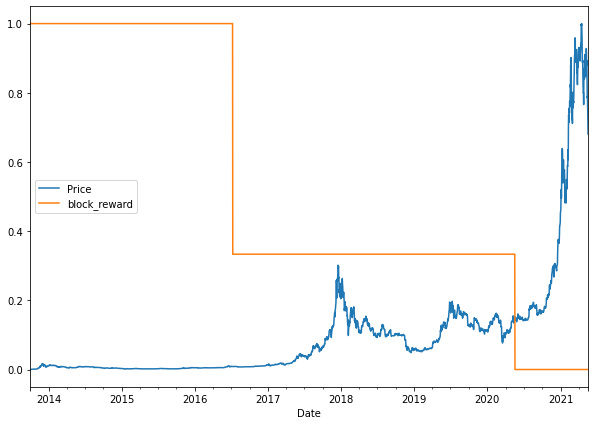

In [128]:
# Plot the block reward vs price over time
from sklearn.preprocessing import minmax_scale
scaled_price_block_df = pd.DataFrame(minmax_scale(bitcoin_prices_block[["Price", "block_reward"]]),
                                     columns=bitcoin_prices_block.columns,
                                     index=bitcoin_prices_block.index)
scaled_price_block_df.plot(figsize=(10, 7))